In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import*
from scipy.integrate import quad

In [2]:
def get_kappas(f,Sigma,sigma_w):
    r=sigma_w**2*np.mean(Sigma)

    k1=quad(lambda x: np.exp(-.5*x**2/r)*x*f(x)/np.sqrt(2*np.pi*r),-np.inf,np.inf)[0]/r


    var=quad(lambda x: np.exp(-.5*x**2/r)*f(x)**2/np.sqrt(2*np.pi*r),-np.inf,np.inf)[0]
    ks=np.sqrt(var-r*k1**2)

    k1,ks=k1**2,ks**2
    
    return k1,ks
    

In [4]:
d=500
k=1500  #width of STUDENT RF

gamma=k/d
sigma_w=sigma_a=1.

Delta=.000


Sigma=np.ones(d)


k1s,kss=get_kappas(f=lambda x: np.tanh(2*x),Sigma=Sigma,sigma_w=sigma_w) #student kappas
k1,ks=get_kappas(f=lambda x: np.tanh(2*x),Sigma=Sigma,sigma_w=sigma_w)




F=np.random.randn(k,d)/np.sqrt(d)*sigma_w

Omega,U=np.linalg.eigh(k1s*F@np.diag(Sigma)@F.T+kss*np.eye(k))
PhiPhiT=np.real(np.diag(U.T@(np.sqrt(k1s*k1)*F@np.diag(Sigma)**2@F.T)@U))

rhow=np.sum(Sigma)/d*sigma_a**2*sigma_w**2
rhoa=sigma_a**2


print(r"$\rho_a={}  \rho_w={}$".format(rhoa,rhow))



$\rho_a=1.0  \rho_w=1.0$


In [6]:
sigma=1.
phi=lambda x: np.tanh(2*x)



f=phi
r1=sigma

k11=quad(lambda x: np.exp(-.5*x**2/r1)*x*f(x)/np.sqrt(2*np.pi*r1),-np.inf,np.inf)[0]/r1


var1=quad(lambda x: np.exp(-.5*x**2/r1)*f(x)**2/np.sqrt(2*np.pi*r1),-np.inf,np.inf)[0]
ks1=np.sqrt(var1-r1*k11**2)

k11,ks1=k11**2,ks1**2

r2=sigma*var1

k12=quad(lambda x: np.exp(-.5*x**2/r2)*x*f(x)/np.sqrt(2*np.pi*r2),-np.inf,np.inf)[0]/r2


var2=quad(lambda x: np.exp(-.5*x**2/r2)*f(x)**2/np.sqrt(2*np.pi*r2),-np.inf,np.inf)[0]
ks2=np.sqrt(var2-r2*k12**2)

k12,ks2=k12**2,ks2**2



In [7]:
def update_overlaps(Vhat,qhat,mhat,lamb):
    V=np.mean(Omega/(lamb+Vhat*Omega))
    q=np.mean((mhat**2*Omega*PhiPhiT+qhat*Omega**2)/(lamb+Vhat*Omega)**2)
    m=np.sqrt(gamma)*sigma_w**2*sigma_a**2*mhat*np.mean(PhiPhiT/(lamb+Vhat*Omega))
    
    return V,q,m

In [8]:
def update_hat_overlaps(alpha, V,q,m):
    Vhat=alpha/(1+V)
    mhat=np.sqrt(gamma)*Vhat*np.sqrt(k11*k12)
    qhat=alpha*(k11*k12+ks1*k12+ks2+q-2*np.sqrt(k11*k12)*m+Delta)/(1+V)**2
    
    return Vhat,qhat,mhat
    
    

In [9]:
damping=0.1

def damp(new, old):
        return (1-damping) * new + damping * old

In [10]:


def iterate(alpha,lamb,max_iter=10000,tol=1e-12,init=None,verbose=False):
    last_flip=None
    V,q,m=1,.7, .7
    Vhat,qhat,mhat=0,0,0
    for i in range(max_iter):
        Vhat,qhat,mhat=update_hat_overlaps(alpha,V,q,m)
        V_tmp,q_tmp,m_tmp=update_overlaps(Vhat,qhat,mhat,lamb)
        if max([np.abs(V_tmp-V),np.abs(q_tmp-q),np.abs(m_tmp-m)])<tol:
            if verbose:
                print("convcerged after {} steps".format(i))
            return V,q,m,Vhat,qhat,mhat
        
        V=damp(V_tmp,V)
        q=damp(q_tmp,q)
        m=damp(m_tmp,m)
       
        
        if verbose:
            print("V{} q{} m{} Vhat{} qhat{} mhat{}".format(V,q,m,Vhat,qhat,mhat))
        
        
        
    print(alpha, "Not converged")

    return V,q,m,Vhat,qhat,mhat
        
        
        

In [11]:
def get_error(alphas,lamb):
    Eg=[]
    V=[]
    Q=[]
    M=[]
    for alpha in alphas:
        v,q,m,_,_,_=iterate(alpha,lamb)
         #print("V{} q{} m{} ".format(v,q,m))
        eg=(k11*k12+ks1*k12+ks2+q-2*np.sqrt(k11*k12)*m+Delta)
        Eg.append(eg)
        V.append(v)
        M.append(m)
        Q.append(q)
        
    return Eg,V,Q,M
        
        
        
        

In [12]:
from scipy.optimize import minimize_scalar

def error_lamb(log_lamb,alpha):
    v,q,m,_,_,_=iterate(alpha,10**(-log_lamb))
         #print("V{} q{} m{} ".format(v,q,m))
    eg=(k11*k12+ks1*k12+ks2+q-2*np.sqrt(k11*k12)*m+Delta)
    return eg

def get_opt_error(alphas):
    Eg=[]
    V=[]
    Q=[]
    M=[]
    L=[]
    for alpha in alphas/gamma:
        
        minimization=minimize_scalar(error_lamb, (-3,10),args=(alpha),tol=1e-12)
        log_lamb=minimization.x
        lamb=10**(-log_lamb)
        #print(lamb)
        v,q,m,_,_,_=iterate(alpha,.2)
         #print("V{} q{} m{} ".format(v,q,m))
        eg=(k11*k12+ks1*k12+ks2+q-2*np.sqrt(k11*k12)*m+Delta)
        Eg.append(eg)
        V.append(v)
        M.append(m)
        Q.append(q)
        L.append(lamb)
        
    return Eg,V,Q,M,L
        
        
        
        
    

In [13]:
alphas=np.linspace(.2,7.1,70)
Eg,V,Q,M,L=get_opt_error(alphas)

0.06666666666666667 Not converged
0.06666666666666667 Not converged
0.26666666666666666 Not converged
0.49999999999999994 Not converged
1.0 Not converged


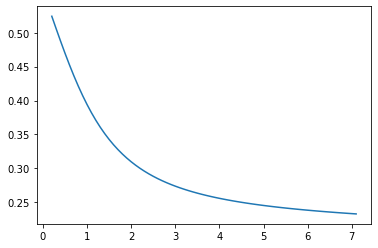

In [14]:
plt.plot(alphas,Eg)